In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import table

from astroML.utils.decorators import pickle_results
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse

from ekfplot import plot as ek
from ekfplot import colors as ec
from ekfstats import sampling, functions

from agrias import utils
import reader

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [3]:
lee = table.Table.read('/Users/kadofong/work/projects/literature_ref/lee2009/tab1_processed.txt', format='mrt')
leer = lee['loghalum'] - lee['loguvlum']
lee['R'] = 10.**leer

In [4]:
merian_sources = reader.merianselect ( )

[merianselect] Only choosing sources at 0.070<z_phot<0.090
[merianselect] Only choosing sources with i_cModelmag_Merian < 22.0
[merianselect] only choosing sources with cmodel/gaap(i) > 1.3


In [20]:
from ekfphys import observer

In [24]:
aha = [ observer.extinction_correction(6563.,x, return_magcorr=True) for x in  merian_sources['AV']]
aha = np.concatenate(aha)

In [31]:
merian_sources['AV']

M3324804415138851598    0.195318
M3324808813185374186    0.107410
M3324808813185374188    0.133562
M3324813211231881880    0.241374
M3324822007324907668    0.204772
                          ...   
M3339216813555746526    0.163913
M3339251997927828822    2.017912
M3339256395974337725    0.111408
M3339291580346429639    0.093274
M3339291580346444953    0.432376
Name: AV, Length: 25046, dtype: float64

In [32]:
observer.extinction_correction(6563., observer.balmerdecrement_to_av(3.25), return_magcorr=True)

array([0.36307778])

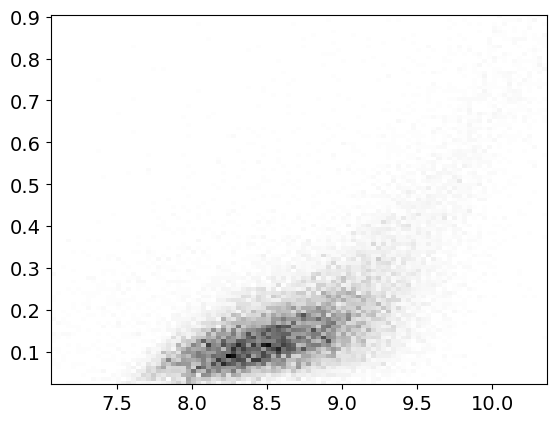

In [26]:
apercorr = merian_sources['i_cModelFlux_Merian']/merian_sources['i_gaap1p0Flux_aperCorr_Merian']
_=ek.hist2d(
    merian_sources['logmass_gaap1p0'] + np.log10(apercorr),
    aha,
    bins=100
)
ms = np.linspace(7., 11., 100)


In [5]:
merian = pd.read_csv('/Users/kadofong/Desktop/tmpx.csv', index_col=0)
#rdet = merian['R']/merian['u_R'] > 6.
rdet = merian ['LHa'] < 3e41 
rdet &= merian['LHa'] > 1e38
merian = merian.loc[rdet]

In [6]:
samples = {}

In [7]:
sample = 'merian'

haunit = 1.#e40 # erg/s
fuvunit = 1.#e28 # erg/s/Hz
func = 1.

if sample == 'merian':
    u_av = 0.1 #merian_sources.reindex(merian.index)['u_AV']
    x = np.log10(merian['LHa']/haunit)
    y = np.log10(merian['LFUV']/fuvunit)
    dx = (merian['LHa']/haunit*np.log(10.))**-1 * func * merian['u_LHa']/haunit
    dx = np.sqrt(dx**2 + u_av**2)
    dy = (merian['LFUV']/fuvunit*np.log(10.))**-1 * func * merian['u_LFUV']/fuvunit
    dy = np.sqrt(dy**2 + u_av**2)
elif sample == 'lee':    
    u_av = 0.1*.1
    x = lee['loghalum']/haunit
    y = lee['loguvlum']/fuvunit
    dx = np.zeros(x.size) + 0.05 #(merian['LHa']/haunit*np.log(10.))**-1 * func * merian['u_LHa']/haunit
    dx = np.sqrt(dx**2 + u_av**2)
    dy = np.zeros(y.size) + 0.05 #(merian['LFUV']/fuvunit*np.log(10.))**-1 * func * merian['u_LFUV']/fuvunit
    dy = np.sqrt(dy**2 + u_av**2)
    
x,y,dx,dy = functions.fmasker(x,y,dx,dy)
#x = x[:1000]
#y = y[:1000]
#dx = dx[:1000]
#dy = dy[:1000]
# stack the results for computation
X = np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T

/Users/kadofong/opt/miniconda3/envs/newmoda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
#------------------------------------------------------------
# compute and save results
ncomponent = 5
@pickle_results(f"{sample}_NC{ncomponent}.pkl")
def compute_XD_results(n_components=10, max_iter=500):
    clf = XDGMM(n_components, max_iter=max_iter)
    clf.fit(X, Xerr)
    return clf


clf = compute_XD_results(ncomponent, 500)

@pickle_results: using precomputed results from 'merian_NC5.pkl'


In [9]:
pull = clf.sample(10000)
samples[sample] = pull

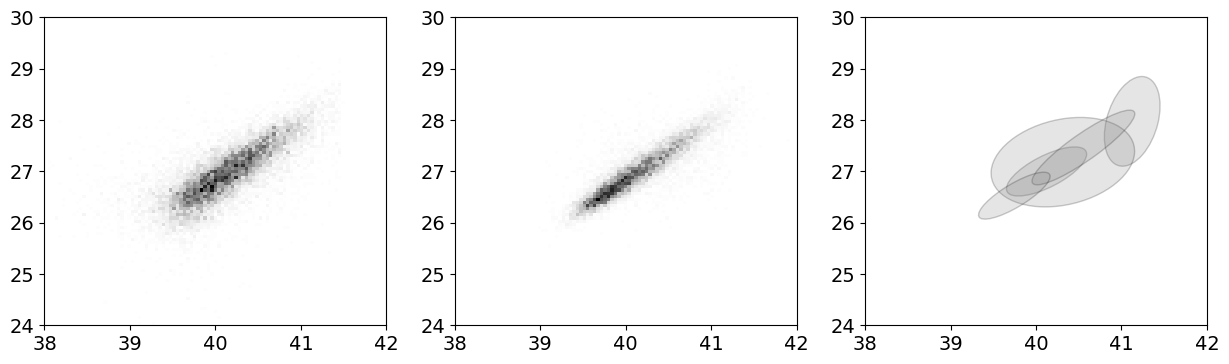

In [10]:
fig, axarr = plt.subplots(1,3,figsize=(15,4))

xbins = np.linspace(38,42,100)/haunit
ybins = np.linspace(24,30,100)/fuvunit
ek.hist2d(
    x, #np.log10(merian['LHa']/haunit),
    y, #np.log10(merian['LFUV']/fuvunit),
    bins=[xbins,ybins],
    ax=axarr[0]
)
ek.hist2d(
    pull[:,0],
    pull[:,1],
    bins=[xbins,ybins],
    ax=axarr[1]
)

for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=axarr[2],
                 ec='k', fc='gray', alpha=0.2)

for ax in axarr:
    ax.set_xlim(xbins.min(), xbins.max())
    ax.set_ylim(ybins.min(), ybins.max())
    #ax.set_xscale('log')
    #ax.set_yscale('log')

#axarr[1].scatter(
#    lee['loghalum'],
#    lee['loguvlum'],
#    s=1
#)

In [11]:
rdist = pull[:,0] - pull[:,1]

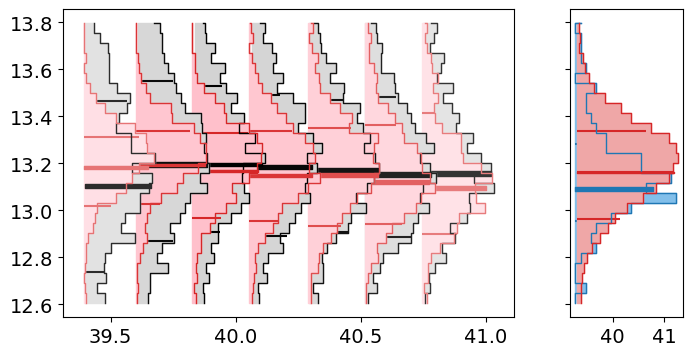

In [12]:
fig, axarr = plt.subplots(1,2,figsize=(8,4), gridspec_kw={'width_ratios':[4.,1.]}, sharey=True)

out,_=ek.histstack( np.log10(merian['LHa']), np.log10(merian['LHa']/merian['LFUV']), xbins=8, ybins=30, ax=axarr[0])
_,_=ek.histstack( pull[:,0], rdist, xbins=out[0], ybins=out[1], edgecolor='tab:red', facecolor='pink', quantilecolor='tab:red',
                ax=axarr[0])
xbins = out[0]
ybins = out[1]

out=ek.histstack(
    lee['loghalum'],
    np.log10(lee['R']),
    xbins = np.array([xbins.min(), xbins.max()]),
    ybins=ybins,
    #orientation='horizontal',
    edgecolor='C0',
    facecolor=ec.ColorBase('C0').modulate(0.3).base,
    quantilecolor='C0',
    ax=axarr[1]
)

out=ek.histstack(
    pull[:,0],
    rdist,
    xbins = np.array([xbins.min(), xbins.max()]),
    ybins=ybins,
    #orientation='horizontal',
    edgecolor='tab:red',
    facecolor=ec.ColorBase('tab:red').modulate(0.3).base,
    quantilecolor='tab:red',
    ax=axarr[1]
)

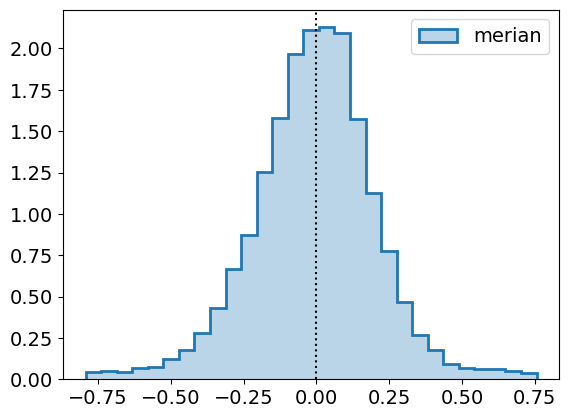

In [13]:
for key in samples.keys():
    mx = samples[key][:,0] - samples[key][:,1]
    mx -= np.median(mx)
    ek.hist(mx, bins=30, label=key, lw=2, alpha=0.3, density=True)
plt.legend ()
plt.axvline(0., color='k', ls=':')

In [14]:
msave = pd.DataFrame(10.**samples['merian'],columns=['LHa','LFUV'])
msave['R'] = 10.**(samples['merian'][:,0] - samples['merian'][:,1])
msave.to_csv('/Users/kadofong/Desktop/merian_xd.csv')

In [15]:
sampling.iqr(rdist)

0.3857844444402243